In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [48]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
import os
import cv2

In [49]:
@pims.pipeline
def gray(image):
    return image[:, :, 0]  # Take just the green channel

IMAGES_PATH = "C:\\Users\\jakub\\Desktop\\graphene\\tests\\outputs\\images\\*.jpg"

frames = pims.open(IMAGES_PATH)
cropped_frames = gray(pims.process.crop(frames, ((0,550),(130,130),(0,0))))

# for frame, idx in enumerate(frames):
#     cropped[idx] = pims.process.crop(frames[idx], ((360,250),(500,550)))

In [50]:
cropped_frames.frame_shape

(474, 1020, 3)

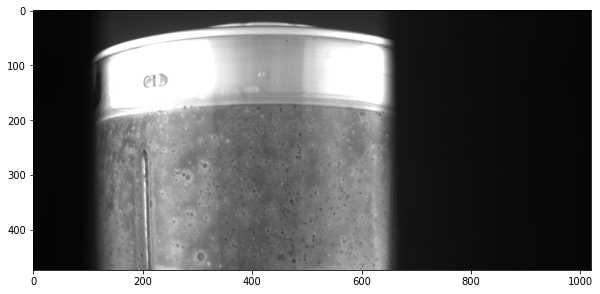

In [51]:
plt.imshow(cropped_frames[0])


In [52]:
f = tp.locate(cropped_frames[0], 13, invert=True, minmass=300)

In [53]:
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
1,18.782995,417.998225,1464.625334,3.651547,0.467471,30.338461,18308.0,0.048218
2,22.653879,490.040483,1363.208192,3.619281,0.499625,31.783150,18078.0,0.048845
4,29.662864,436.974720,1291.551636,3.545297,0.598152,35.828278,10034.0,0.089631
5,30.102049,396.086111,1395.858156,3.544524,0.652513,41.029157,9066.0,0.099644
6,30.284551,459.857964,1206.315007,3.503053,0.644524,37.561904,9499.0,0.094902


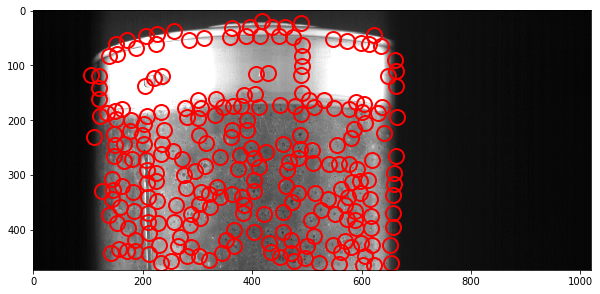

In [54]:
tp.annotate(f, cropped_frames[0]);

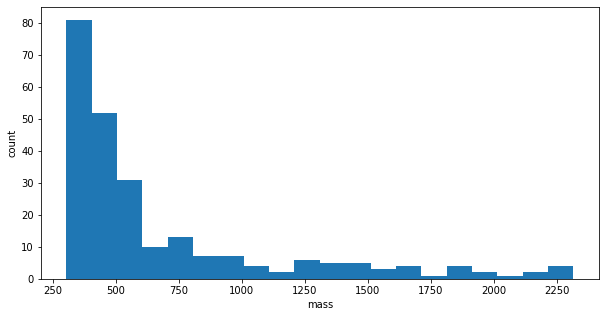

In [55]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

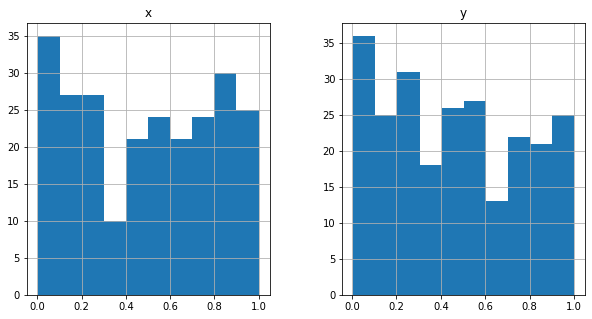

In [56]:
tp.subpx_bias(f)

In [57]:
f = tp.batch(cropped_frames[:25], 13, minmass=300, invert=True);

Frame 24: 249 features


In [58]:
t = tp.link(f, 5, memory=3)

Frame 24: 249 trajectories present.


In [59]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,18.782995,417.998225,1464.625334,3.651547,0.467471,30.338461,18308.0,0.048218,0,0
155,333.008607,484.043818,369.262414,2.921910,0.260144,20.225641,16129.0,0.054898,0,1
156,333.220903,597.673001,364.928348,2.166469,0.090470,22.248205,11700.0,0.076416,0,2
157,335.091618,321.042885,444.675161,2.834738,0.094014,16.469450,12618.0,0.070674,0,3
158,334.659735,363.130435,305.696114,3.751496,0.222377,6.067692,15850.0,0.055889,0,4


In [60]:
t1 = tp.filter_stubs(t, 2)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 580
After: 431


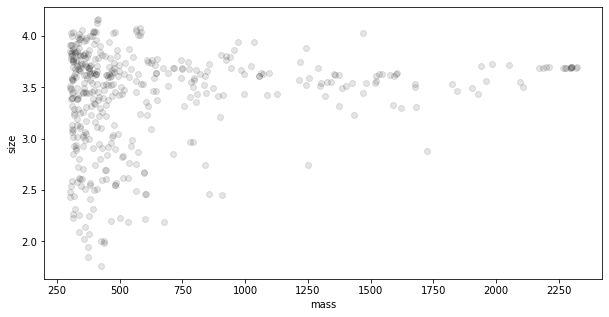

In [61]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [62]:
t2 = t1[((t1['mass'] < 1200) & (t1['size'] < 3.75) &
         (t1['ecc'] < 0.3))]
t2.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,333.008607,484.043818,369.262414,2.921910,0.260144,20.225641,16129.0,0.054898,0,1
0,333.220903,597.673001,364.928348,2.166469,0.090470,22.248205,11700.0,0.076416,0,2
0,335.091618,321.042885,444.675161,2.834738,0.094014,16.469450,12618.0,0.070674,0,3
0,341.038631,341.098234,523.555160,3.473171,0.070661,14.735824,14903.0,0.059539,0,6
0,340.425816,574.259149,584.232082,2.651073,0.102709,26.293333,12897.0,0.069096,0,7


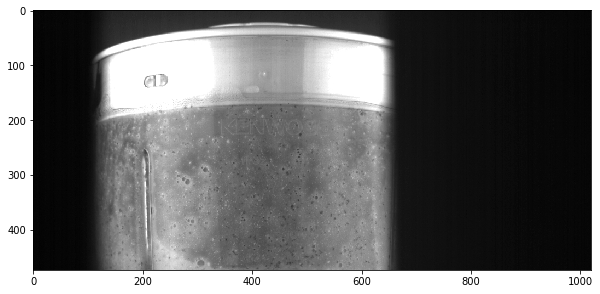

In [63]:
plt.figure()
tp.annotate(t2[t2['frame'] == 99], cropped_frames[99]);

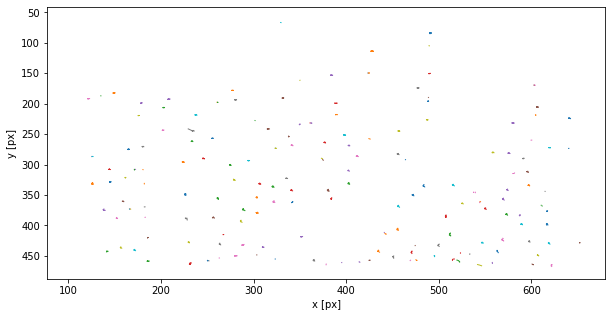

In [64]:
plt.figure()
tp.plot_traj(t2);

In [65]:
col_names = ['dx', 'dy', 'x', 'y', 'frame', 'particle']
# Creating an empty dataframe to store results
data = pd.DataFrame(np.zeros(shape=(1, 6), dtype=np.int64), columns=col_names)
    
for item in set(t.particle):      
        sub = t[t.particle==item]
        
        if sub.shape[0]<=2:
            # Cases in which particle only has 1 or 2 rows of data
            pass
        else:    
            #print('Deriving velocities for particle:', str(item))
            dvx = pd.DataFrame(np.gradient(sub.x), columns=['dx',])
            dvy = pd.DataFrame(np.gradient(sub.y), columns=['dy',])
        
            new_df = pd.concat((dvx, dvy, sub.x.reset_index(drop=True), sub.y.reset_index(drop=True),
                                sub.frame.reset_index(drop=True), sub.particle.reset_index(drop=True)),
                                axis=1, names=col_names, sort=False)
            data = pd.concat((data, new_df), axis=0)
    
# This is to get rid of the first 'np.zeros' row and to reset indexes
data = data.reset_index(drop=True)
data = data.drop(0)
data = data.reset_index(drop=True)

(-0.5, 1019.5, 473.5, -0.5)

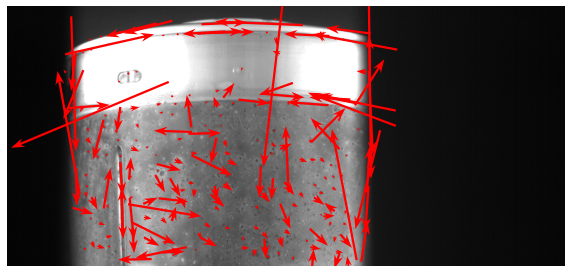

In [66]:
i =0
d = data[data.frame==i]
plt.imshow(cropped_frames[i])
plt.quiver(d.x, d.y, d.dx, -d.dy, pivot='middle', headwidth=4, headlength=6, color='red')
plt.axis('off')